In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import G, R_earth, M_solar
from helpers import load_data, sample_from_distribution, np_histogram_distribution
from math import pi

In [2]:
star_data = load_data("white_dwarf_data.csv")
star_data

,wdid,logg,mass,cgs_mass,r,id
368,SDSS J160420.40+055542.3,9.535,1.380,2.744820e+33,0.362473,0
366,SDSS J114829.00+482731.2,9.365,1.319,2.623491e+33,0.430981,1
372,WD 1253+385,8.789,1.088,2.164032e+33,0.759714,2
363,SDSS J091145.12+353135.6,8.756,1.069,2.126241e+33,0.782212,3
360,SDSS J012339.94+405241.9,8.659,1.011,2.010879e+33,0.850572,4
...,...,...,...,...,...,...
132,Gaia DR2 2521858084423378176,6.789,0.115,2.287350e+32,2.469930,373
135,Gaia DR2 256087115787263616,6.634,0.084,1.670760e+32,2.523338,374
348,Gaia DR2 740483560857296768,6.565,0.074,1.471860e+32,2.564198,375
361,SDSS J013441.30-092212.7,6.579,0.077,1.531530e+32,2.573837,376


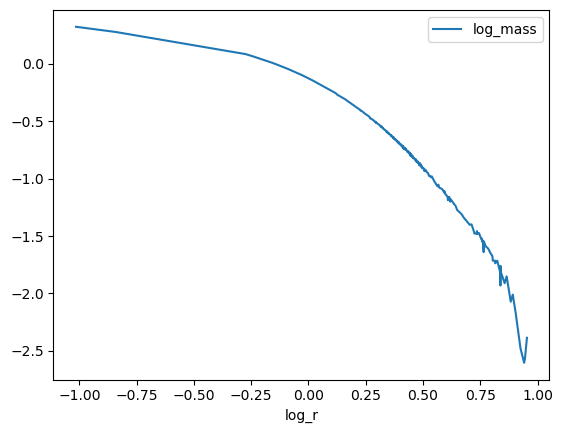

In [3]:
# Plot data in log log scale to see the power law

star_data["log_mass"] = np.log(star_data["mass"])
star_data["log_r"] = np.log(star_data["r"])

star_data.plot("log_r","log_mass")
plt.savefig("outlier.jpg")
plt.show()

We want to find the m point that gives the best correlation between variables and least error

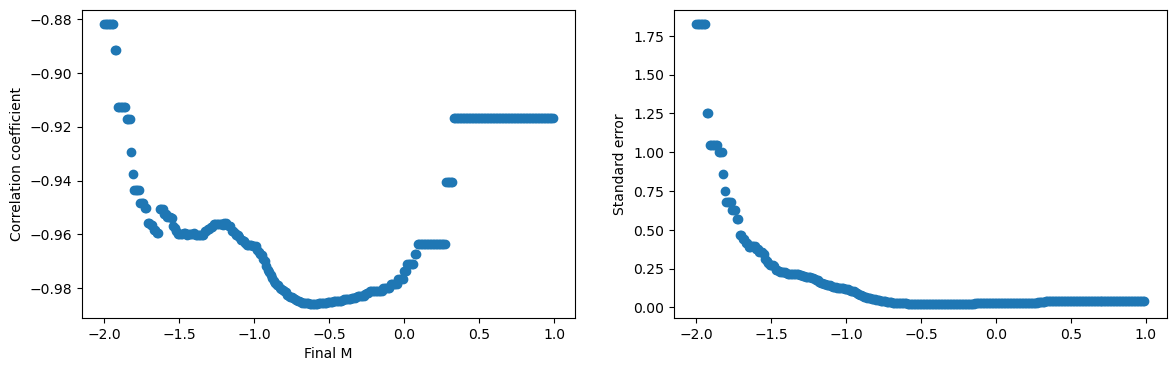

In [4]:
from scipy.stats import linregress
def evaluate_fit(log_r, log_m, mf):
    """
    Fit a line to log_r vs log_m plot and evaluate its performance for log_m < mf
    
    :param log_r: Values of logarithm R 
    :param log_m: Values of logarithm M
    :param mf: Maximum mass of the fit
    :return: 
    """
    
    index = (log_m <= mf)
    
    log_r = log_r[index]
    log_m = log_m[index]
    
    slope, intercept, r, p, se = linregress(log_r, log_m)
    
    return r, se

m_vec = np.arange(-2., 1, 0.01)
fit_data = np.array([evaluate_fit(star_data["log_r"], star_data["log_mass"],mf) for mf in m_vec])

fig, ax=plt.subplots(1,2, figsize=(14,4))
ax[0].scatter(m_vec, fit_data[:,0])
ax[0].set_ylabel("Correlation coefficient")
ax[0].set_xlabel("Final M")

ax[1].scatter(m_vec, fit_data[:,1])
ax[1].set_ylabel("Standard error")
plt.show()

Correlation attains the best value at (for negative correlation lower is better) Mf = -0.5. At that point, standard error is also low, therefore we choose our stopping point as -0.5

/tmp/ipykernel_5561/844406647.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outlier_data["fitted_log_mass"] = non_outlier_data["log_r"]*slope + intercept


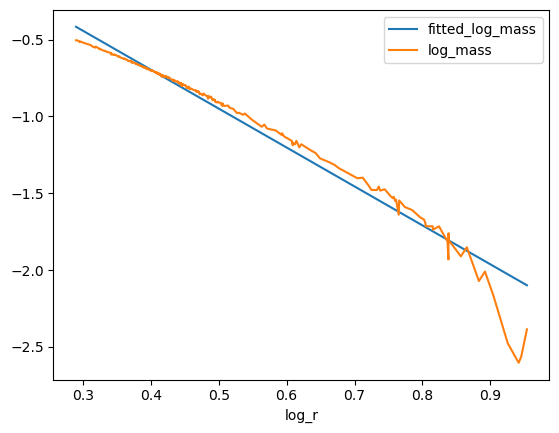

In [5]:
logM_f = -0.5

non_outlier_data = star_data[star_data["log_mass"] <= logM_f]
slope, intercept = np.polyfit(non_outlier_data["log_r"],non_outlier_data["log_mass"], 1)
non_outlier_data["fitted_log_mass"] = non_outlier_data["log_r"]*slope + intercept
non_outlier_data.plot(x="log_r", y=["fitted_log_mass", "log_mass"])
plt.show()

In [6]:
slope

-2.5347505799688737

$$
\begin{align*}
M &\propto R^{\frac{3-n}{1-n}} \\
\implies \log{M} &\propto \frac{3-n}{1-n}\log{R} \\
\text{Slope} &= \frac{3-n}{1-n} \approx -2.5 \\
\implies n &\approx \frac{55}{35}\\
n &= \frac{q}{5-q} \\
\implies q&\approx \frac{275}{90} \approx 3 \\
\implies n &= \frac{3}{2}
\end{align*}
$$

Now, we integrate Lame-Emden equation for this value of n and find $$\xi_n \hspace{0.25cm} \text{and} \hspace{0.25cm} \theta'(\xi_n)$$ 

Details are in integrator.ipynb. We now want to solve the root finding problem of R(rho_c) = R_data for a given K

$$
R = \xi_n\Bigg(\frac{(n+1)K}{4 \pi G}\Bigg)^{1/2}\rho_c^{\frac{1-n}{2n}} \\
\rho_c = \Bigg(\frac{(n+1)K}{4 \pi G}\Bigg)^{\frac{n}{n-1}}\xi^{\frac{2n}{n-1}}R^{\frac{2n}{1-n}} \\
M = 4 \pi \rho_c R^3\Big(\frac{-\theta'(\xi_n)}{\xi_n}\Big)
$$

Our fit parameter is K. Given K, for every R value in the data, we first find rho from second equation and use the calculated rho to predict M.
Then, we compare calculated M to mass data and evaluate the goodness of the fit.
We try to find the K value that minimizes the error.

In [7]:
final_ksi =  3.6544725075459743
final_derivative = -0.20279686220784998
n = 3/2

# Define a class whose instances take K as argument and finds central density of a given R
class FitRho:
    global final_ksi, n
    def __init__(self, K):
        self.K = K
        self.exponent = 2*n/(1-n)
        
    def __call__(self, R):
        return ((((n+1)*self.K)/(4*pi*G))**(n/(n-1)))*pow(R/final_ksi, self.exponent)
    
# predict M from calculated central density
def predict_M(rho, R):
    global final_ksi, final_derivative
    return 4*pi*rho*pow(R,3)*((-final_derivative)/final_ksi)

# Define a class whose instances takes radius-mass data and returns the average relative difference between predicted
# masses and true masses for a given K

class FitK:
    def __init__(self, R_data, M_data):
        self.R_data = R_data
        self.M_data = M_data
        
    def __call__(self, K):
        rho_fitter = FitRho(K)
        rho_data = [rho_fitter(R) for R in self.R_data]
        return np.mean(np.abs(self.M_data - np.array([predict_M(rho, R) for rho,R in zip(rho_data, self.R_data)]))**2/self.M_data)


In [8]:
from scipy.optimize import minimize

R_data = non_outlier_data["r"].values
M_data = non_outlier_data["mass"].values

objective = FitK(R_data, M_data)

# We select the initial K as the K calculated from y intercept of linear fit
K0 = np.exp(((n-1)/n)*(intercept-np.log(4*pi*(-final_derivative)*pow(final_ksi, (n+1)/(n-1))*pow(((n+1)/(4*pi*G)), n/(n-1)))))
print("Initial K: ", K0)

result = minimize(objective, K0, method="Nelder-Mead")
result

Initial K:  3.1501289040619334e-08


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.09067573677734812
             x: [ 3.111e-08]
           nit: 4
          nfev: 8
 final_simplex: (array([[ 3.111e-08],
                       [ 3.130e-08]]), array([ 9.068e-02,  9.073e-02]))

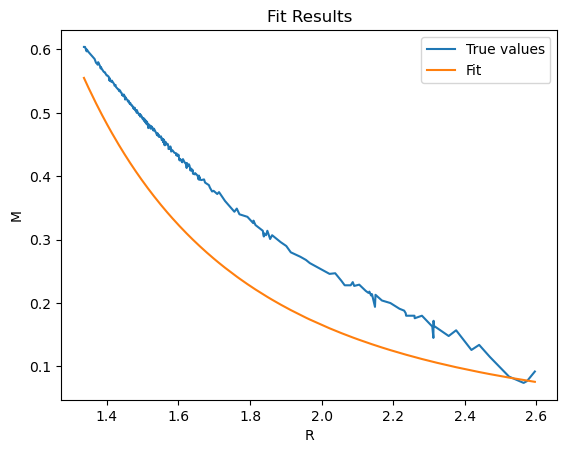

In [9]:
K_star = result.x
rho_fitter = FitRho(K_star)
rho_data = [rho_fitter(R) for R in R_data]
M_predictions = [predict_M(rho, R) for rho,R in zip(rho_data, R_data)]

plt.plot(R_data, M_data, label="True values")
plt.plot(R_data, M_predictions, label="Fit")
plt.xlabel("R")
plt.ylabel("M")
plt.title("Fit Results")
plt.legend()
plt.show()


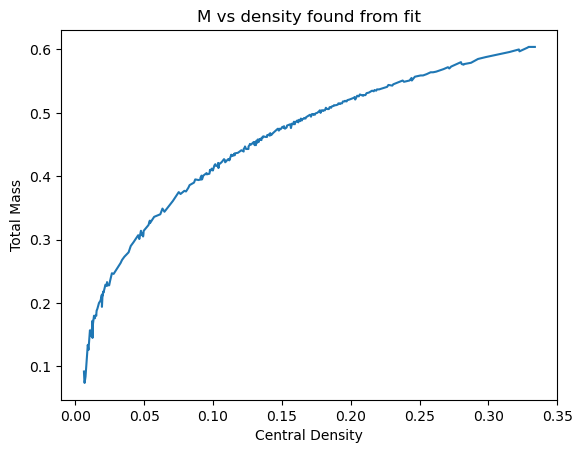

In [70]:
plt.plot(rho_data, M_data)
plt.xlabel("Central Density")
plt.ylabel("Total Mass")
plt.title("M vs density found from fit")
plt.show()

## Interpolation

Data is not homogenously distributed. We need to tackle with this problem.

We first visualize the distribution of R values to make a reasonable selection of sample points.

We construct the distribution and sample from it to calculate at which points we should calculate $\rho_c$

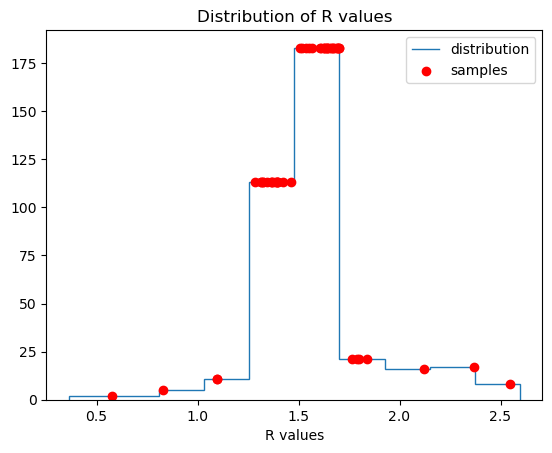

In [171]:
num_sample_points = 50

def find_count(r, edges, dist):
    return dist[[1 if ((r >= edge[0]) and (r < edge[1])) else 0 for edge in edges].index(1)]

R_data = star_data["r"]
M_data = star_data["mass"]

dist, bins = np_histogram_distribution(R_data)
edges = [(bins[i], bins[i+1]) for i in range(0,len(bins)-1)]

sample_points = sample_from_distribution(dist, bins, num_sample_points)
sample_counts = [find_count(r, edges, dist) for r in sample_points]

plt.stairs(dist, bins, label="distribution")
plt.scatter(sample_points, sample_counts, c="r", label="samples")
plt.xlabel("R values")
plt.title("Distribution of R values")
plt.legend()
plt.show()


### Guessing central density 

Honestly, I had hard time understanding the instructions of this part so I will just do what I was able to understand.

I had sampled points from data, namely, 30 out of 348. I will do the exact same procedure that I did above for these 30 points to find a K.

Then, I will fit a spline to find central density from a given R point from the data. With central density and R known, I can calculate M from




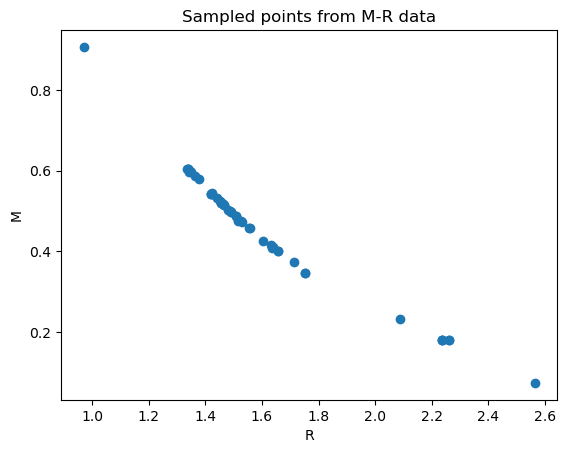

In [172]:
# Map sample points to nearest data points
sampled_idxes = [np.argmin(np.abs(R_data - r)) for r in sample_points]

sampled_R_data = R_data[sampled_idxes]
sampled_M_data = M_data[sampled_idxes]

plt.title("Sampled points from M-R data")
plt.xlabel("R")
plt.ylabel("M")
plt.scatter(sampled_R_data, sampled_M_data)
plt.show()

In [207]:
from math import asinh
from scipy.optimize import minimize

def EOS(rho, D ,q=3):
    global K_star
    C = 5*K_star*(D**(5/q))/8
    
    x = rho/D**(1/q)
    
    return np.array(C*(x*(2*x**2 - 3)*(x**2 + 1)**0.5 + 3*asinh(x))).flatten()[0]


def RHS_new(r, vec, D):
    """
    :param r: radius 
    :param vec: (m, P)
    :return: RHS of the newtonian gravity
    """
    
    m,P = vec
    
    rho = minimize(lambda rho: EOS(rho,D)-P, (P/K_star)**(3/5)).x
    rho = np.array(rho).flatten()[0]
    
    dmdr = 4*pi*r**2*rho
    dPdr = (-G*m/r**2)*rho
    
    return np.array([dmdr, dPdr], dtype=float)


def RK4(ksi, vec, D, dx):
    assert (not np.any(np.isnan(vec))) or (not np.any(np.isinf(vec)))
    
    k1 = dx*RHS_new(ksi, vec, D)
    k2 = dx*RHS_new(ksi+0.5*dx, vec + 0.5*k1, D)
    k3 = dx*RHS_new(ksi+0.5*dx, vec + 0.5*k2, D)
    k4 = dx*RHS_new(ksi+dx,vec + k3, D)

    vec += (k1 + 2*k2 + 2*k3 + k4)/6
    return vec

def solve_IVP(D, rho_c, dx=1e-4, tol=1e-7):
    vec0 = np.array([0, EOS(rho_c, D)])
    
    r0 = 1e-4
    
    vec_arr = []
    while abs(vec0[-1]) > tol:
        vec0 = RK4(r0, vec0, D, dx)
        print(vec0[-1])
        r0 += dx
        vec_arr.append(vec0)
        
    return r0, vec_arr
    

In [208]:
D = 2
rho_c = 0.4

solve_IVP(D, rho_c)

(0.0001, [])